In [1]:
%load_ext autoreload
%autoreload 2

## 1. Read in data, pre-process and create the model

In [13]:
# read in pickled cifar-10 data
import pickle
import numpy as np
import matplotlib.pyplot as plt
from milligrad import Tensor

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

x = []
y = []
for i in range(1, 6):
    data = unpickle(f'data/cifar10/data_batch_{i}')
    x.append(data[b"data"].astype(np.float32))
    y.append(np.array(data[b"labels"]))
    
x = np.concatenate(x)
y = np.concatenate(y)
n_train = len(x) - 5000
idx_shuffle = np.random.permutation(len(x))
x_train, x_val = x[idx_shuffle][:n_train], x[idx_shuffle][n_train:]
y_train, y_val = y[idx_shuffle][:n_train], y[idx_shuffle][n_train:]

test = unpickle('data/cifar10/test_batch')
x_test, y_test = test[b"data"].astype(np.float32), np.array(test[b"labels"])

# normalize the input data with the mean and std of the training data
mean, std = x_train.mean(), x_train.std()
x_train, x_val, x_test = (x_train - mean) / std, (x_val - mean) / std, (x_test - mean) / std

# one-hot encode the labels
y_train, y_val, y_test = np.eye(10)[y_train], np.eye(10)[y_val], np.eye(10)[y_test]

x_train.shape, x_val.shape
# ((45000, 3072), (5000, 3072))

((45000, 3072), (5000, 3072))

In [20]:
# read in the data and convert the pixel values to float32
train = unpickle('data/cifar10/data_batch_1')
val = unpickle('data/cifar10/data_batch_2')
test = unpickle('data/cifar10/test_batch')
x_train, y_train = train[b"data"].astype(np.float32), np.array(train[b"labels"])
x_val, y_val = val[b"data"].astype(np.float32), np.array(val[b"labels"])
x_test, y_test = test[b"data"].astype(np.float32), np.array(test[b"labels"])


# drop 70% of val for ease of use
ind = int(len(x_val)*0.3)
ind = np.random.permutation(len(x_val))[:ind] # there may otherwise be some structure in the data
x_val, y_val = x_val[ind], y_val[ind]

# normalize the input data with the mean and std of the training data
mean, std = x_train.mean(), x_train.std()
x_train, x_val, x_test = (x_train - mean) / std, (x_val - mean) / std, (x_test - mean) / std

# one-hot encode the labels
y_train, y_val, y_test = np.eye(10)[y_train], np.eye(10)[y_val], np.eye(10)[y_test]

In [22]:
def accuracy(y, y_hat):
    return np.mean(y.argmax(axis=1) == y_hat.argmax(axis=1))

In [23]:
class GD:
    def __init__(self, params:list[Tensor], lr:float=0.01):
        self.params = params
        self.lr = lr

    def step(self):
        for p in self.params:
            p.data -= self.lr * p.grad  
            
    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)
            
class CyclicScheduler:
    def __init__(self, opt, lr_start: float, lr_end: float, stepsize: int):
        self.opt = opt
        self.lr_start = lr_start
        self.lr_end = lr_end
        self.stepsize = stepsize
        
        self.t = 0  # Current step within the cycle

    def step(self):
        cycle = self.t // (2 * self.stepsize)
        x = abs(self.t / self.stepsize - 2 * cycle - 1)
        lr = self.lr_start + (self.lr_end -  self.lr_start) * max(0, (1 - x))
        self.opt.lr = lr
        self.t += 1

        if self.t >= 2 * self.stepsize:
            self.t = 0

## 5.1.a. Increasing the number of hidden nodes.

In [ ]:
import math
from milligrad import Tensor

# 10x bigger than before
class MLP: 
    def __init__(self):
        self.w1 = Tensor.randn(3072, 512) / math.sqrt(3072) # Xavier/Glorot initialization (sometimes done with d_in+d_out)
        self.b1 = Tensor.zeros(512)
        self.w2 = Tensor.randn(512, 10) / math.sqrt(512)
        self.b2 = Tensor.zeros(10)
        
    def __call__(self, x:Tensor) -> Tensor:
        x = (x @ self.w1 + self.b1).relu()
        return x @ self.w2 + self.b2 # for numerical stability, we don't use softmax here but do log_softmax in the loss function
    
    def parameters(self)->list[Tensor]: return [self.w1, self.b1, self.w2, self.b2]
    
test = MLP()
test.w1.mean(), test.w1.std().mean(), 1 / math.sqrt(3072)
# mean is close to zero and std is close to 1/sqrt(3072) as expected 

In [40]:
from tqdm import tqdm

np.random.seed(400)
NS = 500
BATCH_SIZE = 100
BATCHES_PER_EPOCH = len(x_train) // BATCH_SIZE
EPOCHS = 1 * math.ceil((2 * NS) / BATCHES_PER_EPOCH) # a bit more than 1 cycle
ETA_MAX = 1e-1
ETA_MIN = 1e-5
LAMBDA = 1e-2


model = MLP()
optim = GD(model.parameters(), lr=ETA_MIN)
sched = CyclicScheduler(optim, lr_start=ETA_MIN, lr_end=ETA_MAX, stepsize=NS)

lrs = []
train_losses_epoch, train_costs_epoch = [], []
val_losses_epoch, val_costs_epoch = [], []
train_accs_epoch, val_accs_epoch = [], []
for _ in tqdm(range(EPOCHS)):
    train_losses, train_costs, train_accs = [], [], []
    permutation = np.random.permutation(len(x_train))
    for i in range(len(x_train) // BATCH_SIZE):
        idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        x = Tensor(x_train[idxs])
        y = Tensor(y_train[idxs])
        y_hat = model(x)
        # cross-entropy loss with L2 regularization cost
        # sum over classes, then mean over batch for cross-entropy
        loss = -(y * y_hat.log_softmax()).sum(axis=-1).mean()
        # here y acts as a selector (due to ohe) so GD minimizes -log(y_hat_correct) i.e. maximizing the likelihood
        cost = LAMBDA * ((model.w1 ** 2).sum() + (model.w2 ** 2).sum())
        
        optim.zero_grad()
        (loss + cost).backward()
        optim.step()
        sched.step()
        
        lrs.append(optim.lr)
        train_losses.append(loss.data)
        train_costs.append(cost.data)
        train_accs.append(accuracy(y.data, y_hat.data))
    
    val_losses, val_accs = [], []
    permutation = np.random.permutation(len(x_val))
    for i in range(len(x_val) // BATCH_SIZE):
        idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        x = Tensor(x_val[idxs])
        y = Tensor(y_val[idxs])
        y_hat_val = model(x)
        val_loss = -(y * y_hat_val.log_softmax()).sum(axis=-1).mean()
        
        val_losses.append(val_loss.data)
        val_accs.append(accuracy(y.data, y_hat_val.data))
    
    train_losses_epoch.append(np.mean(train_losses))
    train_costs_epoch.append(np.mean(train_costs))
    train_accs_epoch.append(np.mean(train_accs))
    
    val_losses_epoch.append(np.mean(val_losses))
    val_costs_epoch.append(cost.data) # L2 doesnt change in validation so we just copy the last value
    val_accs_epoch.append(np.mean(val_accs))
    

100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


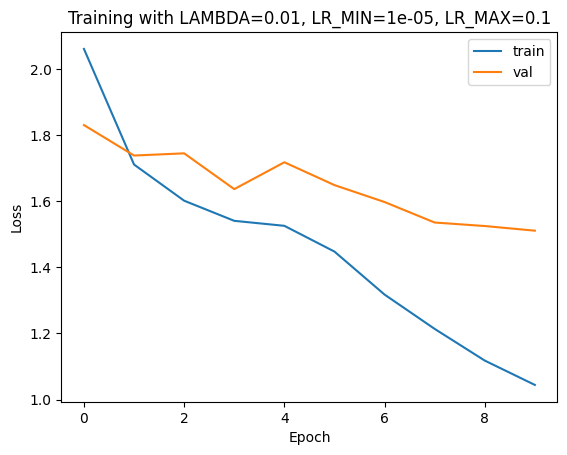

In [41]:
plt.plot(train_losses_epoch, label="train")
plt.plot(val_losses_epoch, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

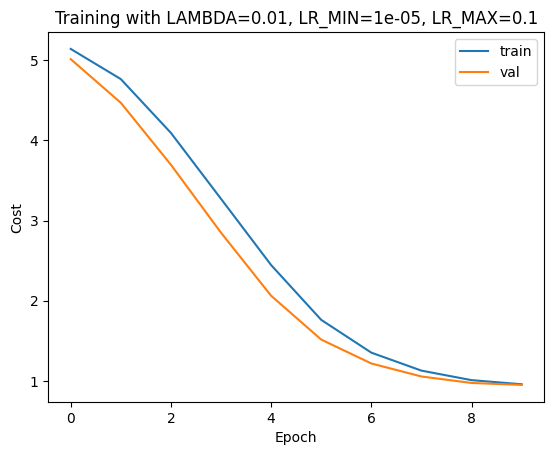

In [42]:
plt.plot(train_costs_epoch, label="train")
plt.plot(val_costs_epoch, label="val")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

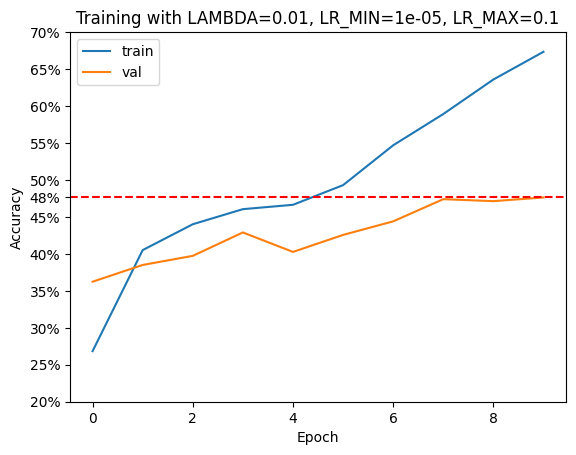

In [43]:
plt.plot(train_accs_epoch, label="train")
plt.plot(val_accs_epoch, label="val")

plt.axhline(max(val_accs_epoch), color="red", linestyle="--")
plt.yticks(list(plt.yticks()[0]) + [max(val_accs_epoch)])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

# normalized_lrs = (lrs - np.min(lrs)) / (np.max(lrs) - np.min(lrs)) * (np.max(train_accs) - np.min(train_accs)) + np.min(train_accs)
# plt.plot(normalized_lrs[::BATCH_SIZE], label="Learning Rate", color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

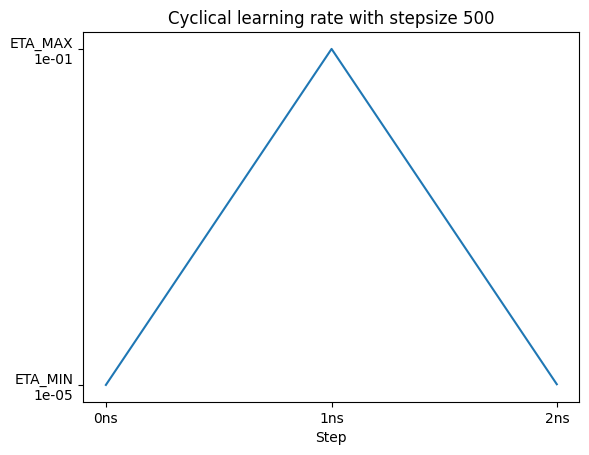

In [44]:
plt.plot(lrs)
plt.xlabel("Step")
plt.title(f"Cyclical learning rate with stepsize {NS}")

steps = len(lrs) // NS + 1
plt.xticks([i*NS for i in range(steps)], [f"{i}ns" for i in range(steps)])
plt.yticks([ETA_MIN, ETA_MAX], [f"ETA_MIN\n{ETA_MIN:0.0e}", f"ETA_MAX\n{ETA_MAX:0.0e}"])

plt.show()

In [45]:
accuracy(y_test, model(Tensor(x_test)).data)
# achieves 45.87% accuracy on the test set

0.4923

### So training on the same subset of data, with the same hyperparameters, but using a larger model resullts in better validation (48% +2% more) and testing accuracy (49% + 3% more).

## 5.1.c. Data Augmentation

In [337]:
def augment_batch(batch:np.ndarray, flip_rate:float=1, translation_rate:float=1)->np.ndarray:
    batch = batch.reshape(-1, 3, 32, 32)
    if np.random.rand() < flip_rate:
        batch = np.flip(batch, axis=2) # horizontal flip
    if np.random.rand() < flip_rate:
        batch = np.flip(batch, axis=3) # vertical flip
    if np.random.rand() < translation_rate: # translate by -6 to 7 pixels
        dx, dy = np.random.randint(-6, 7, size=2)
        batch = np.roll(batch, shift=(dx, dy), axis=(2, 3)) # shifts by dx and dy, replacing with pixels from the other side

    return batch.reshape(-1, 3*32*32)        

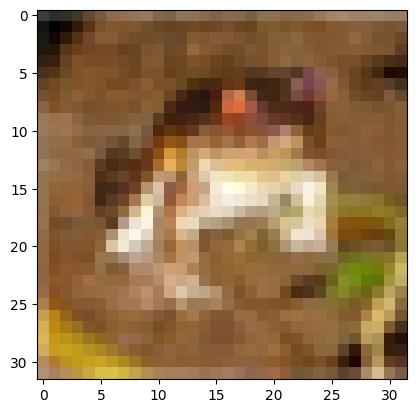

In [338]:
verify = x_train[:1].copy() * std + mean

plt.imshow(verify.reshape(3, 32, 32).transpose(1, 2, 0).astype(np.uint8))

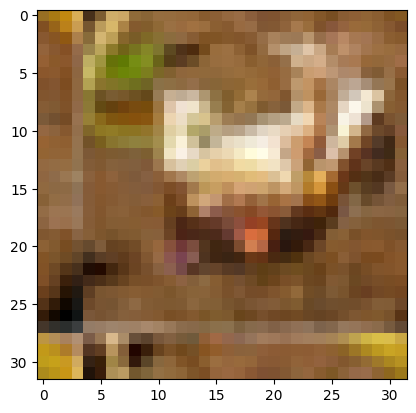

In [339]:
plt.imshow(augment_batch(verify).reshape(3, 32, 32).transpose(1, 2, 0).astype(np.uint8))

## Train with data augmentation

In [300]:
from tqdm import tqdm

np.random.seed(400)
NS = 500
BATCH_SIZE = 100
BATCHES_PER_EPOCH = len(x_train) // BATCH_SIZE
EPOCHS = 1 * math.ceil((2 * NS) / BATCHES_PER_EPOCH) # a bit more than 1 cycle
ETA_MAX = 1e-1
ETA_MIN = 1e-5
LAMBDA = 1e-2


model = MLP()
optim = GD(model.parameters(), lr=ETA_MIN)
sched = CyclicScheduler(optim, lr_start=ETA_MIN, lr_end=ETA_MAX, stepsize=NS)

def train_with_augmentations(model, optim, sched, x_train, y_train, x_val, y_val):
    lrs = []
    train_losses_epoch, train_costs_epoch = [], []
    val_losses_epoch, val_costs_epoch = [], []
    train_accs_epoch, val_accs_epoch = [], []
    for _ in tqdm(range(EPOCHS)):
        train_losses, train_costs, train_accs = [], [], []
        permutation = np.random.permutation(len(x_train))
        for i in range(len(x_train) // BATCH_SIZE):
            idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            x = Tensor(augment_batch(x_train[idxs])) # perform data augmentation
            y = Tensor(y_train[idxs])
            y_hat = model(x)
            # cross-entropy loss with L2 regularization cost
            # sum over classes, then mean over batch for cross-entropy
            loss = -(y * y_hat.log_softmax()).sum(axis=-1).mean()
            # here y acts as a selector (due to ohe) so GD minimizes -log(y_hat_correct) i.e. maximizing the likelihood
            cost = LAMBDA * ((model.w1 ** 2).sum() + (model.w2 ** 2).sum())
            
            optim.zero_grad()
            (loss + cost).backward()
            optim.step()
            sched.step()
            
            lrs.append(optim.lr)
            train_losses.append(loss.data)
            train_costs.append(cost.data)
            train_accs.append(accuracy(y.data, y_hat.data))
        
        val_losses, val_accs = [], []
        permutation = np.random.permutation(len(x_val))
        for i in range(len(x_val) // BATCH_SIZE):
            idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            x = Tensor(x_val[idxs])
            y = Tensor(y_val[idxs])
            y_hat_val = model(x)
            val_loss = -(y * y_hat_val.log_softmax()).sum(axis=-1).mean()
            
            val_losses.append(val_loss.data)
            val_accs.append(accuracy(y.data, y_hat_val.data))
        
        train_losses_epoch.append(np.mean(train_losses))
        train_costs_epoch.append(np.mean(train_costs))
        train_accs_epoch.append(np.mean(train_accs))
        
        val_losses_epoch.append(np.mean(val_losses))
        val_costs_epoch.append(cost.data) # L2 doesnt change in validation so we just copy the last value
        val_accs_epoch.append(np.mean(val_accs))
        
    return (train_losses_epoch, train_costs_epoch, train_accs_epoch), (val_losses_epoch, val_costs_epoch, val_accs_epoch), lrs


(train_losses_epoch, train_costs_epoch, train_accs_epoch), (val_losses_epoch, val_costs_epoch, val_accs_epoch), lrs = train_with_augmentations(model, optim, sched, x_train, y_train, x_val, y_val)

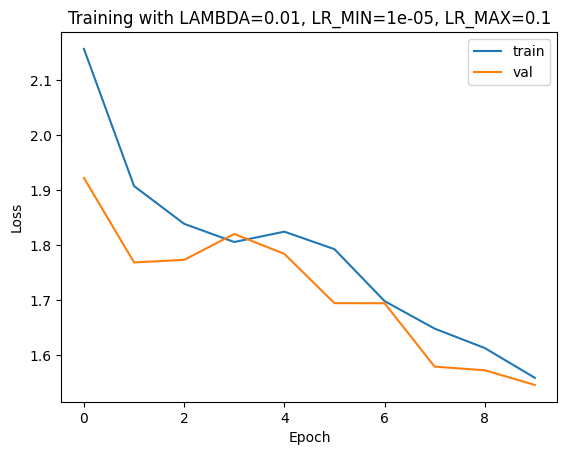

In [275]:
plt.plot(train_losses_epoch, label="train")
plt.plot(val_losses_epoch, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

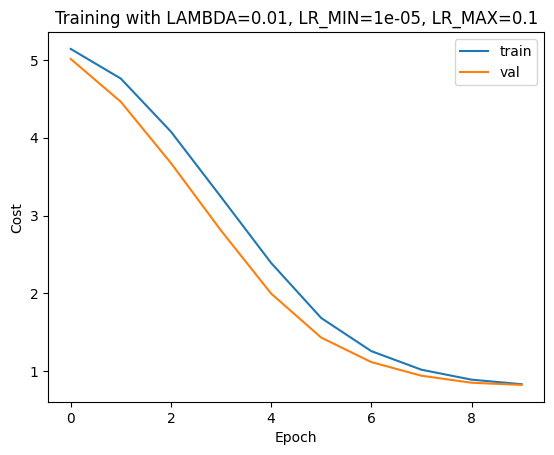

In [276]:
plt.plot(train_costs_epoch, label="train")
plt.plot(val_costs_epoch, label="val")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

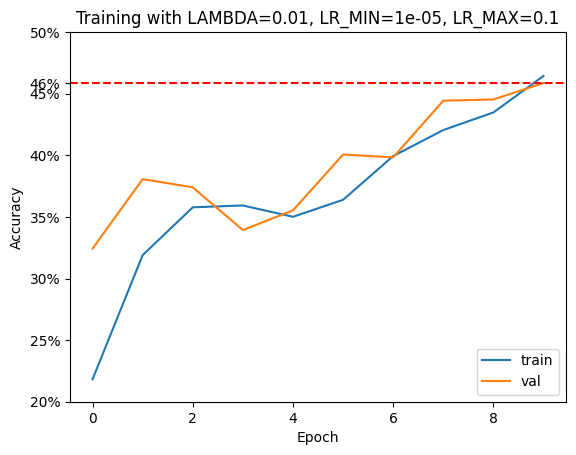

In [277]:
plt.plot(train_accs_epoch, label="train")
plt.plot(val_accs_epoch, label="val")

plt.axhline(max(val_accs_epoch), color="red", linestyle="--")
plt.yticks(list(plt.yticks()[0]) + [max(val_accs_epoch)])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

# normalized_lrs = (lrs - np.min(lrs)) / (np.max(lrs) - np.min(lrs)) * (np.max(train_accs) - np.min(train_accs)) + np.min(train_accs)
# plt.plot(normalized_lrs[::BATCH_SIZE], label="Learning Rate", color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

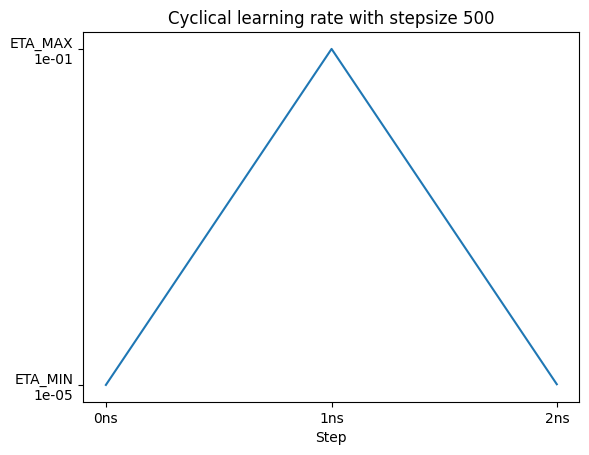

In [278]:
plt.plot(lrs)
plt.xlabel("Step")
plt.title(f"Cyclical learning rate with stepsize {NS}")

steps = len(lrs) // NS + 1
plt.xticks([i*NS for i in range(steps)], [f"{i}ns" for i in range(steps)])
plt.yticks([ETA_MIN, ETA_MAX], [f"ETA_MIN\n{ETA_MIN:0.0e}", f"ETA_MAX\n{ETA_MAX:0.0e}"])

plt.show()

In [279]:
accuracy(y_test, model(Tensor(x_test)).data)
# achieves 47.12% accuracy on the test set

0.4774

## 5.2 Finding good hyperparameters for a wide MLP with data augmentation

In [301]:
np.random.seed(400)
NS = 500
BATCH_SIZE = 100
BATCHES_PER_EPOCH = len(x_train) // BATCH_SIZE
EPOCHS = 1 * math.ceil((2 * NS) / BATCHES_PER_EPOCH) # a bit more than 1 cycle
ETA_MAX = 1e-1
ETA_MIN = 1e-5


LAMBDA_MAX_POWER = -1
LAMBDA_MIN_POWER = -5
NUM_SAMPLES = 10
LAMBDAS = 10**(np.random.uniform(LAMBDA_MIN_POWER, LAMBDA_MAX_POWER, NUM_SAMPLES))


results = {}
for l in LAMBDAS:
    np.random.seed(400)
    model = MLP()
    optim = GD(model.parameters(), lr=ETA_MIN)
    sched = CyclicScheduler(optim, lr_start=ETA_MIN, lr_end=ETA_MAX, stepsize=NS)

    LAMBDA = l
    train_res, val_res, lrs = train_with_augmentations(model, optim, sched, x_train, y_train, x_val, y_val)
    results[l] = {
        "train_losses": train_res[0], "train_costs": train_res[1], "train_accs": train_res[2],
        "val_losses": val_res[0], "val_costs": val_res[1], "val_accs": val_res[2],
        "lrs": lrs
    }



100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


In [304]:
best_lambda, best_results = max(results.items(), key=lambda x: max(x[1]["val_accs"]))

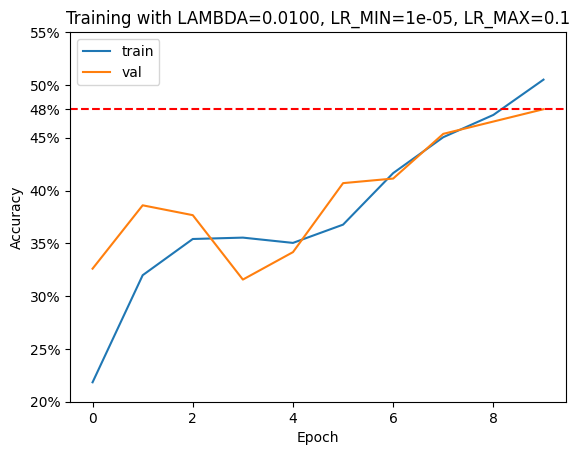

In [305]:
plt.plot(best_results["train_accs"], label="train")
plt.plot(best_results["val_accs"], label="val")

plt.axhline(max(best_results["val_accs"]), color="red", linestyle="--")
plt.yticks(list(plt.yticks()[0]) + [max(best_results["val_accs"])])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

# normalized_lrs = (lrs - np.min(lrs)) / (np.max(lrs) - np.min(lrs)) * (np.max(train_accs) - np.min(train_accs)) + np.min(train_accs)
# plt.plot(normalized_lrs[::BATCH_SIZE], label="Learning Rate", color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training with LAMBDA={LAMBDA:.4f}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


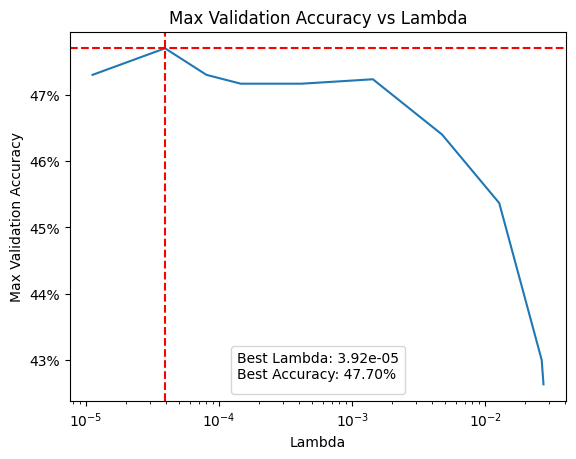

In [306]:
lambdas = sorted(results.keys())
max_val_accs = [max(results[l]["val_accs"]) for l in lambdas]

plt.plot(lambdas, max_val_accs)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
plt.axhline(max(best_results["val_accs"]), color="red", linestyle="--")
plt.axvline(best_lambda, color="red", linestyle="--")
plt.legend(
    title=f"Best Lambda: {best_lambda:.2e}\nBest Accuracy: {max(best_results['val_accs']):.2%}",
)


plt.xlabel("Lambda")
plt.ylabel("Max Validation Accuracy")
plt.title("Max Validation Accuracy vs Lambda")
plt.xscale("log")
plt.show()

## 5.3. Adam Optimizer

In [307]:
# Adam is essentially AdaGrad and RMSProp with bias correction
class Adam:
    def __init__(self, params: list[Tensor], lr: float = 0.001, beta1: float = 0.9, beta2: float = 0.999, epsilon: float = 1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [np.zeros_like(p.data) for p in self.params]
        self.v = [np.zeros_like(p.data) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * p.grad ** 2
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            p.data -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            
    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)

In [323]:
np.random.seed(400)
NS = 500
BATCH_SIZE = 100
BATCHES_PER_EPOCH = len(x_train) // BATCH_SIZE
EPOCHS = 1 * math.ceil((2 * NS) / BATCHES_PER_EPOCH) # a bit more than 1 cycle
ETA = 3e-4
LAMBDA = 0.0

model = MLP()
optim = Adam(model.parameters(), lr=ETA)
sched = CyclicScheduler(optim, lr_start=ETA, lr_end=ETA, stepsize=NS) # perform no learning rate annealing

(train_losses_epoch, train_costs_epoch, train_accs_epoch), (val_losses_epoch, val_costs_epoch, val_accs_epoch), lrs = train_with_augmentations(model, optim, sched, x_train, y_train, x_val, y_val)

100%|██████████| 10/10 [01:01<00:00,  6.13s/it]


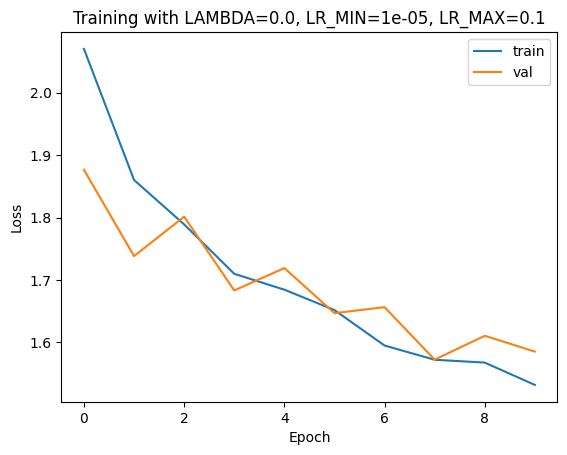

In [324]:
plt.plot(train_losses_epoch, label="train")
plt.plot(val_losses_epoch, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

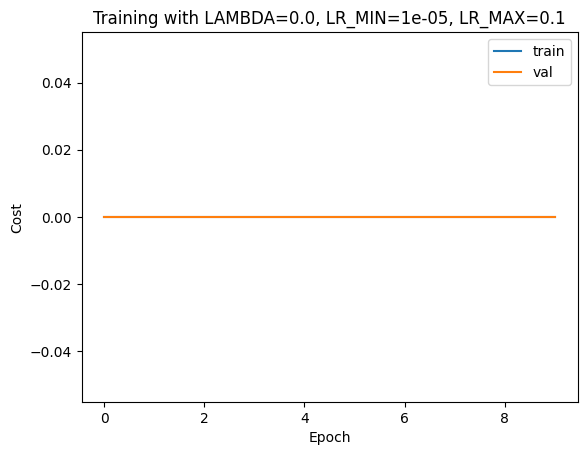

In [325]:
plt.plot(train_costs_epoch, label="train")
plt.plot(val_costs_epoch, label="val")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

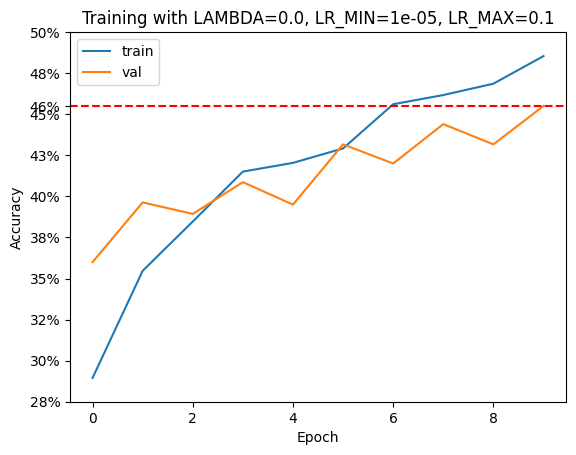

In [326]:
plt.plot(train_accs_epoch, label="train")
plt.plot(val_accs_epoch, label="val")

plt.axhline(max(val_accs_epoch), color="red", linestyle="--")
plt.yticks(list(plt.yticks()[0]) + [max(val_accs_epoch)])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

# normalized_lrs = (lrs - np.min(lrs)) / (np.max(lrs) - np.min(lrs)) * (np.max(train_accs) - np.min(train_accs)) + np.min(train_accs)
# plt.plot(normalized_lrs[::BATCH_SIZE], label="Learning Rate", color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

In [327]:
accuracy(y_test, model(Tensor(x_test)).data)

0.4635

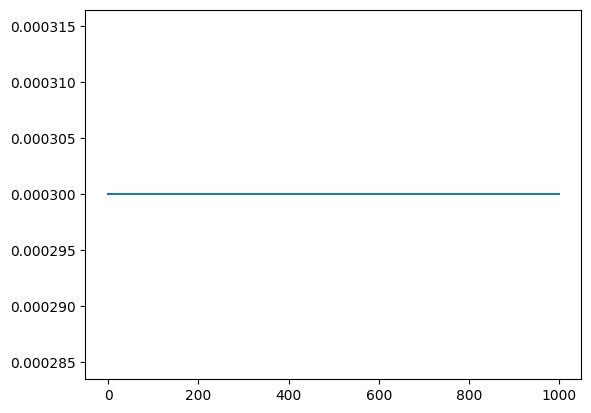

In [322]:
plt.plot(lrs)

In [340]:
np.random.seed(400)
NS = 500
BATCH_SIZE = 100
BATCHES_PER_EPOCH = len(x_train) // BATCH_SIZE
EPOCHS = 1 * math.ceil((2 * NS) / BATCHES_PER_EPOCH) # a bit more than 1 cycle
ETA = 3e-4
LAMBDA = 0.0

model = MLP()
optim = GD(model.parameters(), lr=ETA)
sched = CyclicScheduler(optim, lr_start=ETA, lr_end=ETA, stepsize=NS) # perform no learning rate annealing

(train_losses_epoch, train_costs_epoch, train_accs_epoch), (val_losses_epoch, val_costs_epoch, val_accs_epoch), lrs = train_with_augmentations(model, optim, sched, x_train, y_train, x_val, y_val)

100%|██████████| 10/10 [00:45<00:00,  4.59s/it]


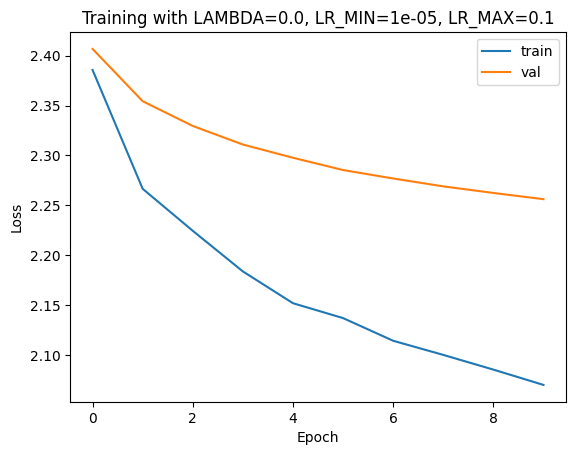

In [341]:
plt.plot(train_losses_epoch, label="train")
plt.plot(val_losses_epoch, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

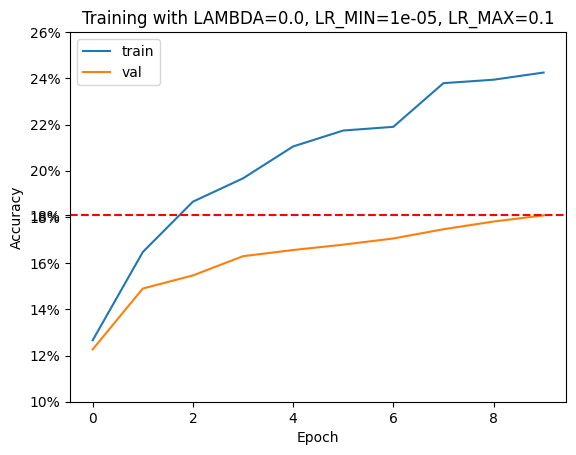

In [342]:
plt.plot(train_accs_epoch, label="train")
plt.plot(val_accs_epoch, label="val")

plt.axhline(max(val_accs_epoch), color="red", linestyle="--")
plt.yticks(list(plt.yticks()[0]) + [max(val_accs_epoch)])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

# normalized_lrs = (lrs - np.min(lrs)) / (np.max(lrs) - np.min(lrs)) * (np.max(train_accs) - np.min(train_accs)) + np.min(train_accs)
# plt.plot(normalized_lrs[::BATCH_SIZE], label="Learning Rate", color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

In [343]:
accuracy(y_test, model(Tensor(x_test)).data)

0.189